## Import liberaries

In [60]:
import laspy
import open3d as o3d
import numpy as np
from shapely.geometry import Polygon, Point, mapping
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../scripts')))

### Read samples

In [65]:
pc_path = '.'
las = '../data/ept-data/10-0-833-513.laz'
las2 = laspy.read('../data/ept-data/10-0-833-513.laz')
pc1 = laspy.read(os.path.join(pc_path,las))
#las

In [57]:
xyz = np.vstack((pc1.x, pc1.y, pc1.z)).transpose()
xyz

array([[-1.11973473e+07,  3.96203758e+06,  6.43630000e+02],
       [-1.11973475e+07,  3.96203656e+06,  6.43680000e+02],
       [-1.11973476e+07,  3.96203561e+06,  6.43750000e+02],
       ...,
       [-1.11973979e+07,  3.96216274e+06,  6.36450000e+02],
       [-1.11973981e+07,  3.96216185e+06,  6.36320000e+02],
       [-1.11973979e+07,  3.96216864e+06,  6.36370000e+02]])

In [58]:
xyz.shape

(27029, 3)

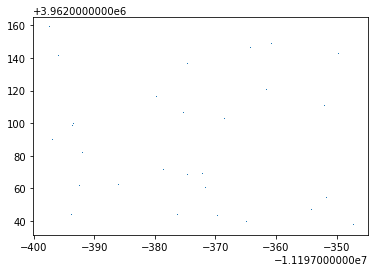

In [62]:
plt.plot(xyz[::1000,0],xyz[::1000,1], ',')

#### Additional Info
- It contains the las header, the point format, point count and vlrs. We can also call them individually to get a separate output for each of them like this

In [66]:
las2.header
las2.header.point_format
las2.header.point_count
las2.vlrs

[<ExtraBytesVlr(extra bytes structs: 2)>, <GeoKeyDirectoryVlr(7 geo_keys)>, <GeoAsciiParamsVlr(['WGS 84 / Pseudo-Mercator|WGS 84|', ''])>]

- see features of the ata points

In [67]:
list(las2.point_format.dimension_names)

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'synthetic',
 'key_point',
 'withheld',
 'scan_angle_rank',
 'user_data',
 'point_source_id',
 'gps_time',
 'ClassFlags',
 'OriginId']

- We have X, Y, and Z for the point data, intensity, classification, GPS time, and some other essential dimensions. Let us, for example, see some of these dimensions.

In [75]:
print('x=',  las2.X)
print('intensity=', las2.intensity)
print('coordinate =', las2.gps_time)

x= [-6834730 -6834747 -6834762 ... -6839794 -6839812 -6839794]
intensity= [314 324 269 ... 144 249 290]
coordinate = [1.99824630e+08 1.99824630e+08 1.99824630e+08 ... 1.99826321e+08
 1.99826321e+08 1.99826321e+08]


- Classification is another essential dimension that you can call with `las.classification` that will provide an array of numbers. 

In [76]:
# classes
classes = set(list(las2.classification))
classes

{1, 2}

- we have only two classes in this data i.e. 1. `Unassigned` and 2. `Ground`
- for more https://desktop.arcgis.com/en/arcmap/latest/manage-data/las-dataset/lidar-point-classification.htm

### Creating, Filtering, and Writing Point Cloud Data
- The output is a 3-dimensional array and looks like this.

In [70]:
point_data = np.stack([las2.X, las2.Y, las2.Z], axis=0).transpose((1, 0))
point_data


array([[-6834730,  4292758,    14563],
       [-6834747,  4292656,    14568],
       [-6834762,  4292561,    14575],
       ...,
       [-6839794,  4305274,    13845],
       [-6839812,  4305185,    13832],
       [-6839794,  4305864,    13837]])

In [73]:
ground = laspy.create(point_format=las2.header.point_format, file_version=las2.header.version)
ground.points = las2.points[las2.classification == 2]

### 3D Point Cloud Visualization
- in this visualizationI use open3d

In [74]:
geom = o3d.geometry.PointCloud()
geom.points = o3d.utility.Vector3dVector(point_data)
o3d.visualization.draw_geometries([geom])

In [26]:
!git add fetch_visual_lidar.ipynb
!git commit -m "visualization using open3d"
!git push

The file will have its original line endings in your working directory


[update_a fffb1d0] visualization using open3d
 1 file changed, 696 insertions(+), 455 deletions(-)
 rewrite example/fetch_visual_lidar.ipynb (96%)


To https://github.com/gezish/USGS_3DEP_Python_LIDAR.git
   0aad06f..fffb1d0  update_a -> update_a


In [28]:
# Generating a data frame given a CRS format and pipe

def generate_geo_df(pipe, epsg):
    try:
        cloud_points = []
        elevations =[]
        geometry_points=[]
        for row in pipe.arrays[0]:
            lst = row.tolist()[-3:]
            cloud_points.append(lst)
            elevations.append(lst[2])
            point = Point(lst[0], lst[1])
            geometry_points.append(point)
        geodf = gpd.GeoDataFrame(columns=["elevation", "geometry"])
        geodf['elevation'] = elevations
        geodf['geometry'] = geometry_points
        geodf = geodf.set_geometry("geometry")
        geodf.set_crs(epsg = epsg, inplace=True)
        return geodf
    except RuntimeError as e:
        print(e)

In [30]:
def generate_polygon(coor, epsg):
    polygon_g = Polygon(coor)
    crs = {'init': 'epsg:'+str(epsg)}
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_g])       
    return polygon

In [47]:
# Co-ordinates for the polygon and generating the polygon from the given co-ordinate

coordinates = [
    [-93.756055, 41.918115],
    [-93.756155, 41.918215],
    [-93.756396, 41.918475],
    [-93.755955, 41.918300],
    [-93.755795, 41.918000],
]


polygon = generate_polygon(coordinates, 4326)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [48]:
def show_on_map(polygon, zoom):
    #region selection
    poly = mapping((polygon.iloc[:,0][0]))
    tmp = poly['coordinates'][0][0]
    anchor = [tmp[1], tmp[0]]
    map = folium.Map(anchor,zoom_start=zoom, tiles='cartodbpositron')
    folium.GeoJson(polygon).add_to(map)
    folium.LatLngPopup().add_to(map)
    return map

show_on_map(polygon, 20)

In [49]:
df = gdf[0]['geo_data']

NameError: name 'gdf' is not defined